In [1]:
import numpy as np
import pandas as pd
import random 
import torch
import regex as re
from nltk.corpus import stopwords
from collections import Counter

from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import RegexpTokenizer 
from collections import OrderedDict
from nltk.corpus import stopwords

from torch import nn
from torch.functional import F
from torch import optim
from tqdm import tqdm

import time

In [2]:
remove_stopwords = True
use_lemmatization = True
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r"\w+")
catchedStopWords = stopwords.words('english')

In [3]:
def tokenize_doc(sent,
                 lemma=False, 
                 remove_stopwords=False):
    
    # a simple tokenizer with case folding and an option to use lemmatization
    sent = sent.lower()
    tokens = sent.split()
    tokens = [*Counter(tokens).keys()]
    
    if lemma:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    if remove_stopwords:
        tokens = [token for token in tokens if token not in catchedStopWords]
    return tokens

def basic_text_processing(corpus, num_words):
    vocab = set()
    all_tokens = []
    
    # tokenization
    for doc in tqdm(corpus):
        tokens = tokenize_doc(doc, lemma=use_lemmatization, remove_stopwords=remove_stopwords)
        vocab.update(set(tokens))
        all_tokens.extend(tokens)
    print("Tokenization complete")
    # TODO START
    # We only want to train with the top num_words MOST FREQUENT words
    # Output a variable called ``train_tokens" that is similar to all_tokens
    # variable but without infrequent words
    freq_words = dict(Counter(all_tokens).most_common(num_words))
    train_tokens = [token for token in all_tokens if token in freq_words]

    # TODO END
    
    # generating vocabulary from the train_tokens
    word_counts = Counter(train_tokens)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) 
    i2w = {ii: word for ii, word in enumerate(sorted_vocab)}
    w2i = {word: ii for ii, word in i2w.items()}
    
    return  w2i, i2w, train_tokens

In [4]:
def get_contexts(words, idx):
    contexts = [words[idx-2], words[idx-1], words[idx+1], words[idx+2]]
    return contexts

In [5]:
def get_batches(words, batch_size):  #, window_size = 4):
    for i in range(0, len(words), batch_size):
        curr = words[i:i + batch_size]   # current batch
        batch_x, batch_y = [], []
        #batch = []
        for ii in range(2,len(curr)-2):
            x = get_contexts(curr, ii)
            y = curr[ii]
            #batch.append((x,y))
            batch_x.append(x)
            batch_y.append(y)
        
        yield batch_x, batch_y
        #yield batch

In [52]:
i = 0
for inputs, targets in get_batches(int_words, batch_size=batch_size):
    i+=1

In [53]:
i

366524

In [6]:
#CC-e woNews dataset contains news articles from news sites all over thrld. 
#The data is available on AWS S3 in the Common Crawl bucket at /crawl-data/CC-NEWS/. 
#This version of the dataset has been prepared using news-please - an integrated web crawler and information extractor for news.
#It contains 708241 English language news articles published between Jan 2017 and December 2019. 
#It represents a small portion of the English language subset of the CC-News dataset.

from datasets import load_dataset
dataset = load_dataset("cc_news")
corpus = dataset['train']['text'][:150000]


Found cached dataset cc_news (/home/nate/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/ae469e556251e6e7e20a789f93803c7de19d0c4311b6854ab072fecb4e401bd6)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# all configurations go here
# TODO
# You will need to set configurations below to a suitable values
# As for learning rate, the current value should work (but you are welcome to change it)
n_vocab = 10000  # maximum size of vocab
n_embed = 200 # size of embedding
lr = 0.001 # learning rate
n_negative_samples = 5 # number negative examples per positive example
ws = 5  # window size
batch_size =  50 # batch size for sampling positive examples
n_epochs =  5 #umber of training epochs
device = 'cpu'

In [8]:
# this cell might take 20 minutes to run, so be patient!
# optional: you might want to save these intermediate results to disk
# so that next time you open Google Colab, you don't need to
# run this again
w2i, i2w, train_tokens = basic_text_processing(corpus, num_words=n_vocab)
int_words = [w2i[token] for token in train_tokens]
print("Vocab Size:", len(w2i))

100%|███████████████████████████████████████████████████████████████████████| 150000/150000 [01:40<00:00, 1498.50it/s]


Tokenization complete
Vocab Size: 10000


### Training

In [43]:
def train_cbow(    w1,
                   w2,
                   int_words,
                   n_vocab,
                   n_embed,
                   learning_rate,
                   n_negative_samples,
                   batch_size,
                   n_epochs,
                   print_every=100):
    
    optimizer = optim.Adam([w1, w2], lr=learning_rate)    
    w1 = torch.nn.init.uniform_(w1, -0.10, +0.10)
    w2 = torch.nn.init.uniform_(w2, -0.10, +0.10)

    step = 0
    
    for epoch in range(n_epochs):
        for inputs, targets in get_batches(int_words, batch_size=batch_size):
            step += 1
            #stime = time.time()

            contexts_indices = torch.LongTensor(inputs).to(device) # number_batches x window_size
            targets_indices = torch.LongTensor(targets).to(device) # number_batches x label
            b_size = contexts_indices.shape[0]
            
            # feedward
            W1 = w1[contexts_indices].mean(1).view(b_size, n_embed,1)
            W2 = w2.expand(b_size,-1,-1)
            o_layer = torch.bmm(W2, W1)
            
            # retrieve vectors of negative examples and negative targets words
            noise_dist = torch.ones((b_size,n_vocab))
            noise_words = torch.multinomial(noise_dist, 
                                            num_samples=n_negative_samples, 
                                            replacement=True)
            noise_words = noise_words.view(b_size,n_negative_samples,1).to(device)
            neg_loss = torch.gather(o_layer, 1, noise_words).sigmoid().log().sum(1)

            # retrieve vectors of targets words and positive context words
            t_id = targets_indices.view(b_size,1,1)
            pos_loss = torch.gather(o_layer, 1, t_id).sigmoid().log()

            # Negative sampling loss
            loss = (-(pos_loss - neg_loss)).mean()
            # optimization
            optimizer.zero_grad()
            loss.backward()
            #print(time.time()-stime)
            #return
            optimizer.step()
            #print(time.time()-stime)
            if (step % print_every) == 0:
                #print(time.time()-stime)
                print("Epoch: {}/{} | Loss: {:.4f}".format(epoch+1, n_epochs, loss.item()))
                



In [38]:
# initialization of W and C weight matrix
w1 = torch.nn.Parameter(torch.zeros((n_vocab, n_embed), dtype=torch.float32))
w2 = torch.nn.Parameter(torch.zeros((n_vocab, n_embed), dtype=torch.float32))

In [44]:
train_cbow(    w1,
               w2,
               int_words,
               n_vocab=n_vocab,
               n_embed=n_embed,
               learning_rate=lr,
               n_negative_samples=n_negative_samples,
               batch_size=batch_size,
               n_epochs=n_epochs,
               print_every=100)

Epoch: 1/5 | Loss: -2.7765
Epoch: 1/5 | Loss: -2.7811
Epoch: 1/5 | Loss: -2.7773
Epoch: 1/5 | Loss: -2.7919
Epoch: 1/5 | Loss: -2.8342
Epoch: 1/5 | Loss: -2.8726
Epoch: 1/5 | Loss: -3.0763
Epoch: 1/5 | Loss: -3.3780
Epoch: 1/5 | Loss: -4.4647
Epoch: 1/5 | Loss: -6.5590
Epoch: 1/5 | Loss: -7.8653
Epoch: 1/5 | Loss: -6.9904
Epoch: 1/5 | Loss: -12.3503


KeyboardInterrupt: 

In [40]:
w1

Parameter containing:
tensor([[ 0.4888,  0.6925, -0.4386,  ...,  0.5499, -0.5829,  0.2354],
        [ 0.5200,  0.4937, -0.5241,  ...,  0.6045, -0.4941,  0.3838],
        [ 0.6135,  0.5949, -0.3794,  ...,  0.6270, -0.4386,  0.2622],
        ...,
        [ 0.2666,  0.0661, -0.2034,  ...,  0.2211, -0.1447,  0.2712],
        [ 0.0115,  0.0729, -0.1519,  ...,  0.1300, -0.1808,  0.0320],
        [ 0.0790,  0.1411, -0.1665,  ...,  0.1357, -0.2064,  0.2172]],
       requires_grad=True)

In [48]:
# final embeddings is the summation of the two matrix (check lecture slides)
embeddings = w1.data.to('cpu').data.numpy()


### Evaluation via Visualization

/home/nate/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nate/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


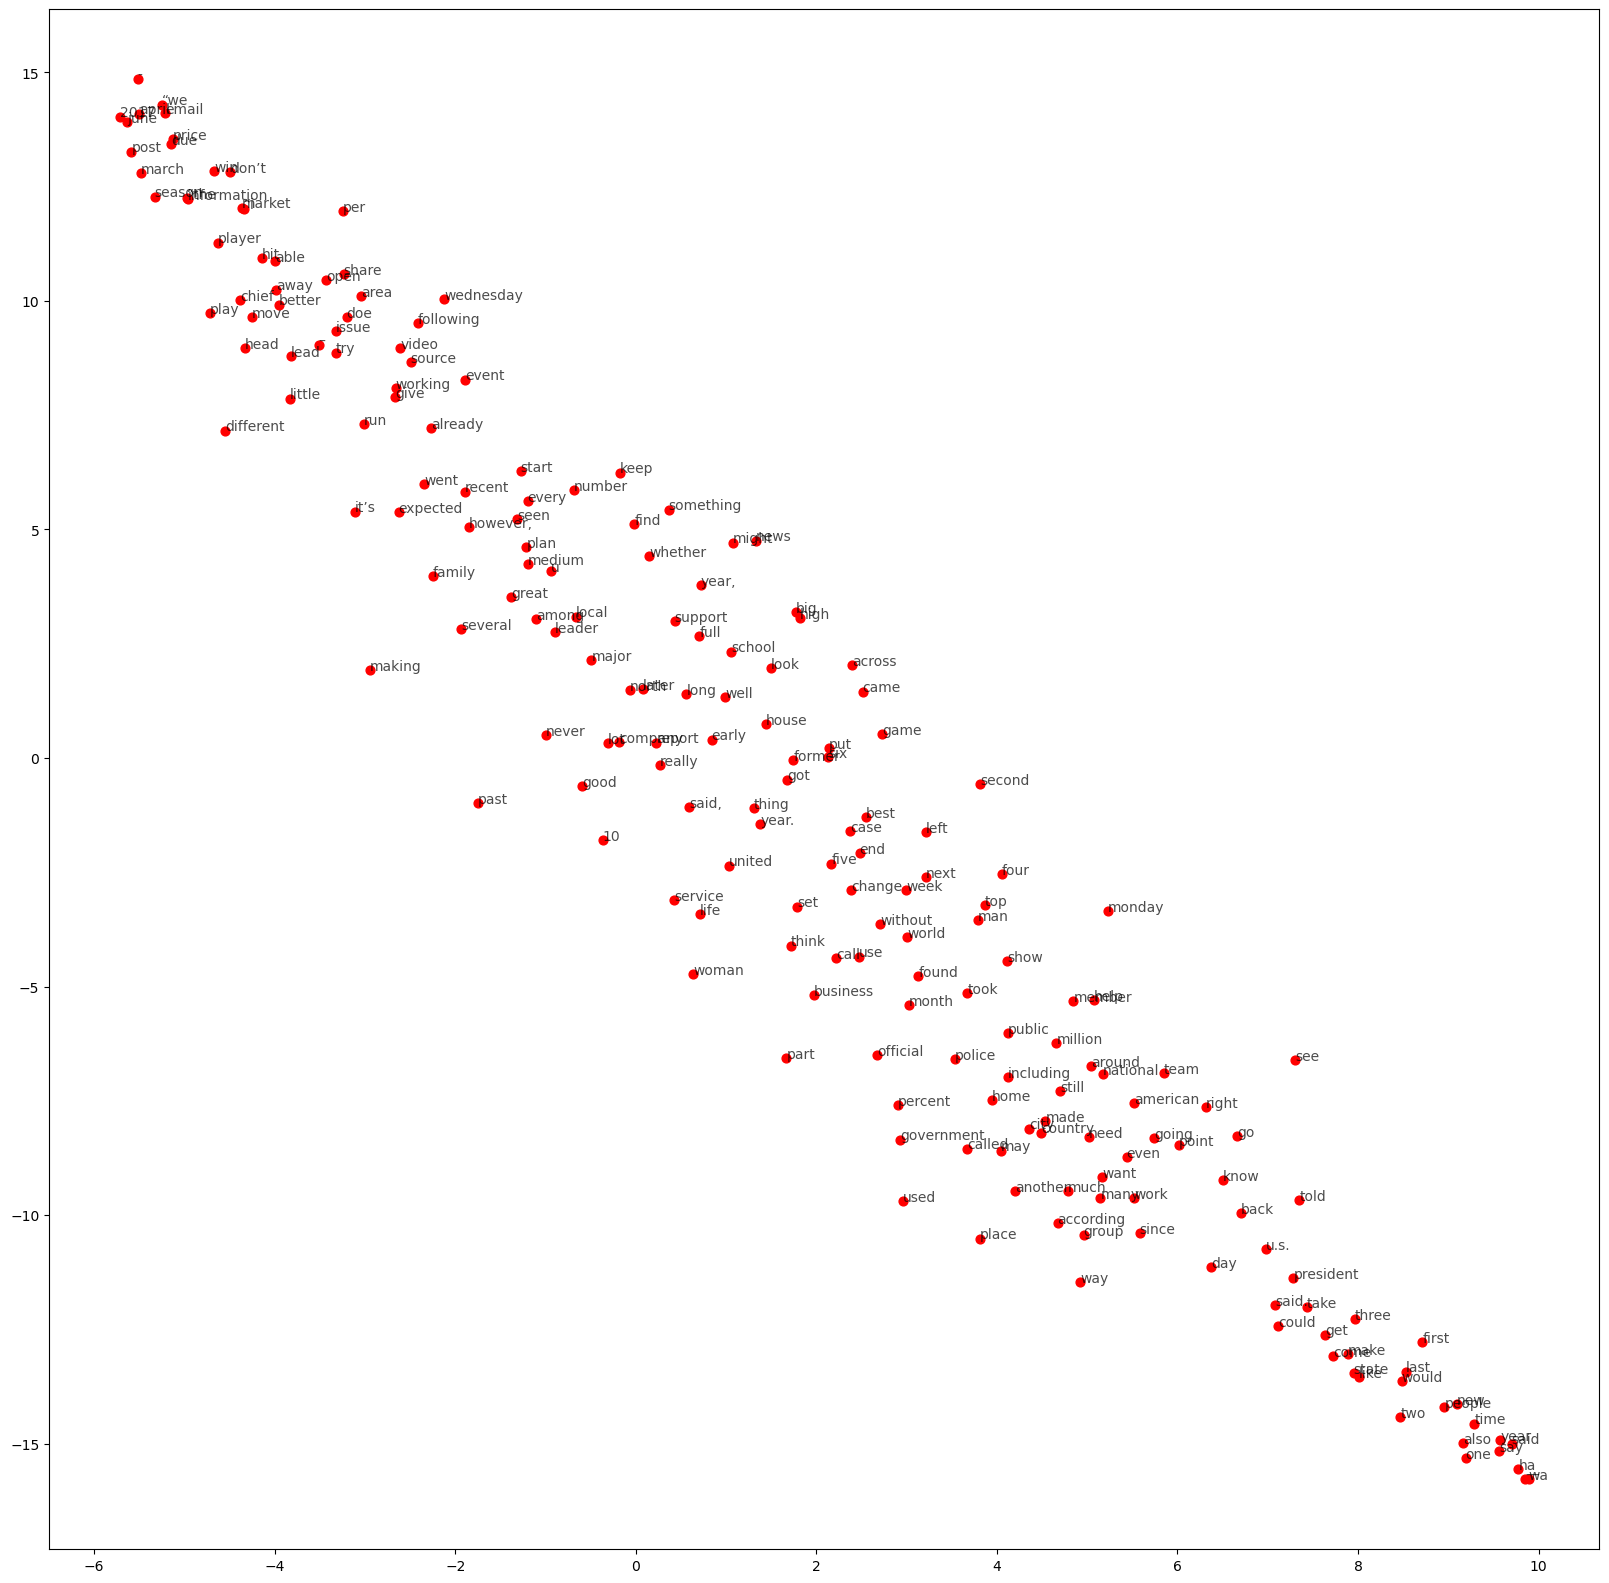

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_viz_words = 200
tsne = TSNE()
embeddings_tsne = tsne.fit_transform(embeddings[:n_viz_words, :])

fig, ax = plt.subplots(figsize = (20, 20))
for i in range(n_viz_words):
    plt.scatter(*embeddings_tsne[i, :], color = 'red', s=40)
    plt.annotate(i2w[i], (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), alpha = 0.7)

### Evaluation via Document Similarity

In [54]:
def transform(query, w2i, embeddings, strategy):
    # TODO
    # input: query or document, vocabulary w2i
    # input: trained word2vec embeddings
    # input: strategy: either 'average' or 'concatenate'
    # output: vector representation of the document query
    w2v_query = tokenize_doc(query, lemma=use_lemmatization, remove_stopwords=remove_stopwords)
    idx = [w2i[word] for word in w2v_query if word in w2i]
    v = [embeddings[i] for i in idx]
    
    assert strategy in ['average', 'concatenate']
    
    # get vectors of each word in the query
    
    # sentence aggregation strategy
    if strategy == 'average':
        # TODO START
        vector = [em.mean() for em in v]
        # vector = 
        # TODO END
    else:
        # TODO START
        vector = np.ravel(v)
        # TODO END
    
    return vector

In [55]:
# test document similarity
q = transform('today I am very happy', w2i, embeddings, strategy='average')
v = transform('today I feel so fascinated', w2i, embeddings, strategy='average')
sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
print("Cosine Similarity: {}".format(sim)) # this score should be high / close to 1.0

Cosine Similarity: 0.751692533493042


In [57]:
v = transform('today I feel so fascinated', w2i, embeddings, strategy='concatenate')
v

array([-0.2766562 , -0.1514462 , -0.09983289,  0.067804  , -0.00822392,
       -0.03254956,  0.07737935, -0.20823477, -0.06492534, -0.02497101,
        0.12592563, -0.03507787, -0.03647686,  0.16883044, -0.13605839,
        0.13299787, -0.16907844,  0.06935725,  0.15487665,  0.09976631,
       -0.18948162, -0.25219342,  0.10340115, -0.12235545,  0.02741729,
        0.27625674, -0.20174374,  0.03936988,  0.02618648,  0.13923043,
       -0.16527507, -0.20957999, -0.02640269,  0.06422225,  0.21696012,
       -0.10724953, -0.22123551,  0.09771737, -0.0122837 ,  0.19675086,
       -0.14386961, -0.09883687, -0.04456416,  0.00972179,  0.18913768,
        0.20162086,  0.03779078,  0.21018153,  0.16261151,  0.06247925,
       -0.23273775,  0.20451804,  0.03313111, -0.22524609, -0.24493055,
       -0.13557668, -0.23861773,  0.26615223, -0.21774149, -0.3021158 ,
       -0.09651285, -0.06945308, -0.10724928,  0.15491399,  0.02467474,
        0.06299543, -0.07783417, -0.28805232, -0.13487613, -0.00

In [65]:
def evaluation(strategy):
    df = pd.read_csv('./quora_train.csv')
    print("Loaded {} pairs".format(len(df)))
    pairs = list(zip(df['question1'].astype(str), df['question2'].astype(str)))
    
    all_sims = []
    
    for doc1, doc2 in tqdm(pairs[:50]):
        q = transform(doc1, w2i, embeddings, strategy=strategy)
        v = transform(doc2, w2i, embeddings, strategy=strategy)
        #print(q,v)
        diff = len(q) - len(v)
        if diff > 0:
            v = np.pad(v, (0, np.abs(diff)))
        else:
            q = np.pad(q, (0, np.abs(diff)))
        
        sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
        all_sims.append(sim)
    return all_sims    
    return np.mean(all_sims)

In [66]:
avg_similarity = evaluation('average')
#print("Final Average Similarity using Average Strategy: {}".format(avg_similarity))

Loaded 13000 pairs


  0%|                                                                                          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_3516259/872978309.py:18: RuntimeWarning: invalid value encountered in double_scalars
  sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4602.85it/s]


In [67]:
avg_similarity

[0.38764283,
 0.31499642,
 0.31399652,
 0.6533786,
 0.7034498,
 0.40633792,
 1.0000001,
 0.90012646,
 nan,
 0.5727866,
 -0.7539391,
 -0.06137571,
 0.30145115,
 0.13786407,
 0.598374,
 -0.45322815,
 0.98055357,
 0.22251558,
 0.7047856,
 0.980657,
 -1.0,
 0.84203446,
 -0.065778755,
 0.9998368,
 -0.30151078,
 -0.4130887,
 1.0,
 0.30253184,
 0.62764376,
 0.4801255,
 0.9855761,
 0.18218216,
 -0.76916146,
 -0.21795963,
 0.99999994,
 0.9995519,
 nan,
 nan,
 0.28113145,
 0.15169972,
 0.962594,
 0.5320286,
 1.0,
 0.45042944,
 -0.48158708,
 0.11128847,
 -0.72683585,
 0.4981326,
 1.0,
 0.7600295]

In [60]:
avg_similarity = evaluation('concatenate')
print("Final Average Similarity using Concatenation Strategy: {}".format(avg_similarity))

Loaded 13000 pairs


  0%|                                                                                       | 0/13000 [00:00<?, ?it/s]/tmp/ipykernel_3516259/530850981.py:18: RuntimeWarning: invalid value encountered in double_scalars
  sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
100%|█████████████████████████████████████████████████████████████████████████| 13000/13000 [00:01<00:00, 7199.44it/s]

Final Average Similarity using Concatenation Strategy: nan
